In [69]:
from omegaconf import OmegaConf
import os, sys
import torch
import glob
import pickle
import pandas as pd
import numpy as np
from scipy.stats import norm as scipy_norm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scienceplots
import time
from thop import profile
from torchinfo import summary
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from models import CuboidTransformerModel
from models.lightning import SEVIRPLModule

In [70]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [87]:
exts = [""] + ["_" + str(i) for i in range(1, 10)]

model_names = {
    
    "EDL (1e-2)" : "mearthformer_edl_1e-2_drop_0",
    "EDL (1e-3)" : "mearthformer_edl_1e-3_drop_0",
    # "EDL (1e-4)" : "mearthformer_edl_1e-4_drop_0",
    "EDL-P (1e-2)" : "mearthformer_edl_1e-2_drop_0_pretrain",
    "EDL-P (1e-3)" : "mearthformer_edl_1e-3_drop_0_pretrain",
    # "EDL-P (1e-4)" : "mearthformer_edl_1e-4_drop_0_pretrain",
    # "MCDO (0.1)" : "mearthformer_drop_0.1",
    "MCDO" : "mearthformer_drop_0.3",
    # "MCDO (0.5)" : "mearthformer_drop_0.5",
    "Ensemble" : ["mearthformer_drop_0.1" + ext for ext in exts],
}

model_names = {
    "EDL (1)" : "earthformer_edl_1_drop_0",
    "EDL (1e-1)" : "earthformer_edl_1e-1_drop_0",
    
#     "EDL (1e-2)" : "earthformer_edl_1e-2_drop_0",
#     "EDL (1e-3)" : "earthformer_edl_1e-3_drop_0",
#     "EDL (1e-4)" : "earthformer_edl_1e-4_drop_0",
}

model_names = {
    "EDL" : "earthformer_edl_1_drop_0",
    "P-EDL" : "earthformer_edl_1_drop_0_pretrain",
    "Ensemble" : ["earthformer_drop_0.1" + ext for ext in exts],
    "MCDO" : "earthformer_drop_0.5",
}

In [88]:
prob = np.linspace(0.01, 0.99, 10)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
plt.style.use('science')

In [89]:
y_all = {}
y_hat_all = {}
epistemic_all = {}
mse_all = {}
time_all = {}
flop_all = {}
size_all = {}

for label, modelname in model_names.items():
    print(modelname)
    if "Ensemble" in label:
        save_dirs = ["../models/experiments/{}/".format(mname) for mname in modelname]
        oc_files = [os.path.join(save_dir, "cfg.yaml") for save_dir in save_dirs]
        checkpoints = [os.path.join(save_dir, "checkpoints/") for save_dir in save_dirs]        
        oc_from_files = [OmegaConf.load(open(oc_file, "r")) for oc_file in oc_files]
        oc_file = oc_files[0]
    else:
        save_dir = "../models/experiments/{}/".format(modelname)
        oc_file = os.path.join(save_dir, "cfg.yaml")
        checkpoints = os.path.join(save_dir, "checkpoints/")

    oc_from_file = OmegaConf.load(open(oc_file, "r"))    
    dataset_oc = OmegaConf.to_object(oc_from_file.dataset)
    micro_batch_size=1
    dm = SEVIRPLModule.get_sevir_datamodule(
            dataset_oc=dataset_oc,
            micro_batch_size=micro_batch_size,
            num_workers=8,)
    dm.prepare_data()
    dm.setup()
    
    if "Ensemble" in label:
        models = []
        ckpts = [glob.glob(checkpoint_dir + '*.ckpt') for checkpoint_dir in checkpoints]
        for c in ckpts:
            c.sort()
        curr_ckpt = [ckpt[1] for ckpt in ckpts]
        print(curr_ckpt)

        for i in range(len(oc_from_files)):
            total_num_steps = SEVIRPLModule.get_total_num_steps(
                epoch=oc_from_files[i].optim.max_epochs,
                num_samples=dm.num_train_samples,
                total_batch_size=oc_from_files[i].optim.total_batch_size,
            )

            pl_module = SEVIRPLModule.load_from_checkpoint(curr_ckpt[i], total_num_steps=total_num_steps, save_dir=modelname[i], oc_file=oc_files[i])
            pl_module.eval()
            models.append(pl_module.torch_nn_module)
    
    else:
        ckpts = glob.glob(checkpoints + '*.ckpt')
        ckpts.sort()
        print(ckpts)
        curr_ckpt = ckpts[-1]
        print(curr_ckpt)
        
        total_num_steps = SEVIRPLModule.get_total_num_steps(
            epoch=oc_from_file.optim.max_epochs,
            num_samples=dm.num_train_samples,
            total_batch_size=oc_from_file.optim.total_batch_size,
        )

        pl_module = SEVIRPLModule.load_from_checkpoint(curr_ckpt, total_num_steps=total_num_steps, save_dir=modelname, oc_file=oc_file)
        if "MCDO" in label:
            pl_module.train()
        else:
            pl_module.eval()
        model = pl_module.torch_nn_module
        
    test_loader = dm.test_dataloader()
    
    # FLOP and Param counter
    ops = 0
    params = 0
    inputs = torch.randn(1, 13, 384, 384, 1).to(device)
    
    if "Ensemble" in label:
        for m in models:
            total_ops, total_params = profile(m, (inputs,), verbose=False)
            ops += total_ops / (1000 ** 3)
            params += total_params / (1000 ** 2)
    elif "MCDO" in label:
        total_ops, total_params = profile(model, (inputs,), verbose=False)
        ops += 10 * total_ops / (1000 ** 3)
        params += total_params / (1000 ** 2)
    elif "EDL" in label:
        total_ops, total_params = profile(model, (inputs,), verbose=False)
        ops += total_ops / (1000 ** 3)
        params += total_params / (1000 ** 2)
    
    flop_all[label] = ops
    size_all[label] = params
    
    y_vals = []
    y_hat_vals = []
    epistemic_vals = []
    mse_vals = []
    time_vals = []
    
    for batch_idx, batch in enumerate(test_loader):
        if batch_idx == 100:
            break
        data_seq = batch['vil'].contiguous()
        x = data_seq[pl_module.in_slice].to(device)
        y = data_seq[pl_module.out_slice].to(device)
        micro_batch_size = x.shape[pl_module.layout.find("N")]
        data_idx = int(batch_idx * micro_batch_size)
        # Start inference time
        start_time = time.time()
        
        if "EDL" in label:
            output = model(x)
            y_hat, v, alpha, beta = torch.split(output, 1, -1)
            aleatoric = beta/(alpha - 1)
            epistemic = aleatoric/v
        elif "MCDO" in label:
            yhats = []
            for i in range(10):
                output = model(x)
                yhats.append(output.detach())

            yhats = torch.cat(yhats, dim=0)
            y_hat = torch.mean(yhats, dim=0)[None, ...]
            epistemic = torch.var(yhats, dim=0)[None, :]
        elif "Ensemble" in label:
            yhats = []
            for i in range(10):
                output = models[i](x)
                yhats.append(output.detach())

            yhats = torch.cat(yhats, dim=0)
            y_hat = torch.mean(yhats, dim=0)[None, ...]
            epistemic = torch.var(yhats, dim=0)[None, :]
            
        # End inference time
        time_vals.append(time.time() - start_time)

        y = y.detach().float().cpu()
        y_hat = y_hat.detach().float().cpu()
        epistemic = epistemic.detach().float().cpu()
        mse = ((y-y_hat)**2).detach().float().cpu()

        y_vals.append(y)
        y_hat_vals.append(y_hat)
        epistemic_vals.append(epistemic)
        mse_vals.append(mse)
        
    y_all[label] = y_vals
    y_hat_all[label] = y_hat_vals
    epistemic_all[label] = epistemic_vals
    mse_all[label] = mse_vals
    time_all[label] = np.array(time_vals).mean()

earthformer_edl_1_drop_0
['../models/experiments/earthformer_edl_1_drop_0/checkpoints/last.ckpt', '../models/experiments/earthformer_edl_1_drop_0/checkpoints/model-epoch=003.ckpt']
../models/experiments/earthformer_edl_1_drop_0/checkpoints/model-epoch=003.ckpt
earthformer_edl_1_drop_0_pretrain
['../models/experiments/earthformer_edl_1_drop_0_pretrain/checkpoints/last.ckpt', '../models/experiments/earthformer_edl_1_drop_0_pretrain/checkpoints/model-epoch=003.ckpt']
../models/experiments/earthformer_edl_1_drop_0_pretrain/checkpoints/model-epoch=003.ckpt
['earthformer_drop_0.1', 'earthformer_drop_0.1_1', 'earthformer_drop_0.1_2', 'earthformer_drop_0.1_3', 'earthformer_drop_0.1_4', 'earthformer_drop_0.1_5', 'earthformer_drop_0.1_6', 'earthformer_drop_0.1_7', 'earthformer_drop_0.1_8', 'earthformer_drop_0.1_9']
['../models/experiments/earthformer_drop_0.1/checkpoints/model-epoch=029.ckpt', '../models/experiments/earthformer_drop_0.1_1/checkpoints/model-epoch=022.ckpt', '../models/experiments

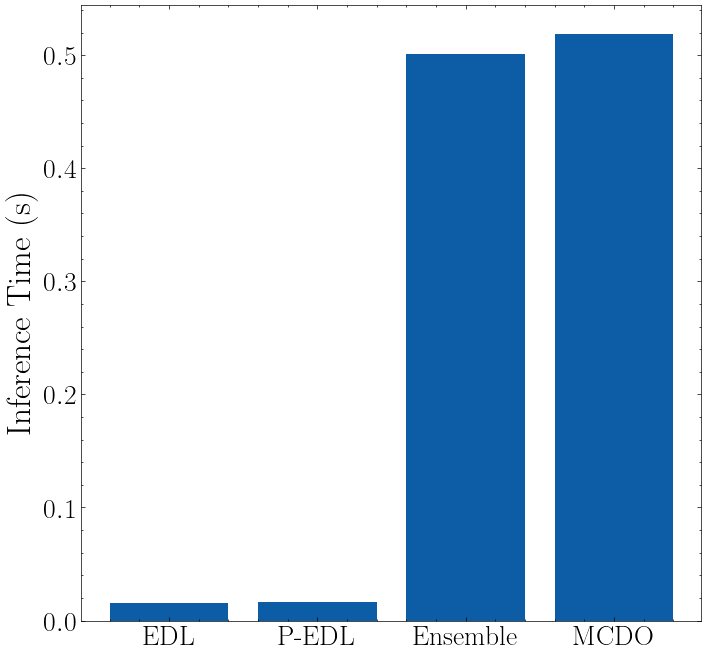

In [96]:
plt.figure(figsize=(8,8))
plt.bar(time_all.keys(), time_all.values())
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel("Inference Time (s)", fontsize=24)
plt.savefig("figures/time.pdf", dpi=300)
plt.show()

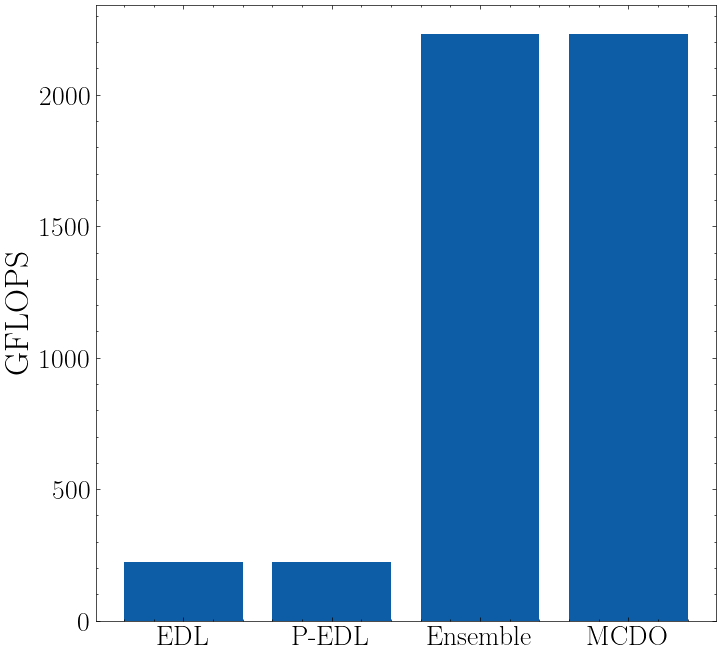

In [97]:
plt.figure(figsize=(8,8))
plt.bar(flop_all.keys(), flop_all.values())
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel("GFLOPS", fontsize=24)
plt.savefig("figures/flops.pdf", dpi=300)
plt.show()

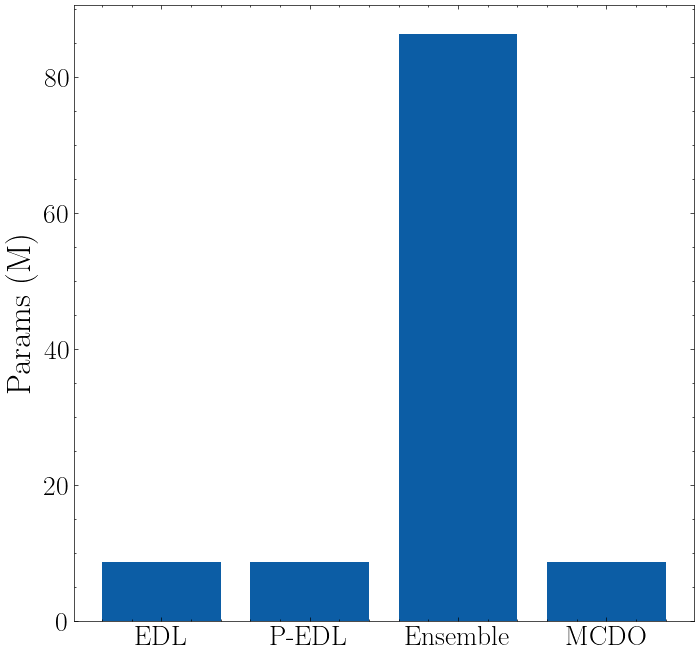

In [98]:
plt.figure(figsize=(8,8))
plt.bar(size_all.keys(), size_all.values())
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel("Params (M)", fontsize=24)
plt.savefig("figures/params.pdf", dpi=300)
plt.show()

earthformer_edl_1_drop_0
earthformer_edl_1_drop_0_pretrain
['earthformer_drop_0.1', 'earthformer_drop_0.1_1', 'earthformer_drop_0.1_2', 'earthformer_drop_0.1_3', 'earthformer_drop_0.1_4', 'earthformer_drop_0.1_5', 'earthformer_drop_0.1_6', 'earthformer_drop_0.1_7', 'earthformer_drop_0.1_8', 'earthformer_drop_0.1_9']
earthformer_drop_0.5


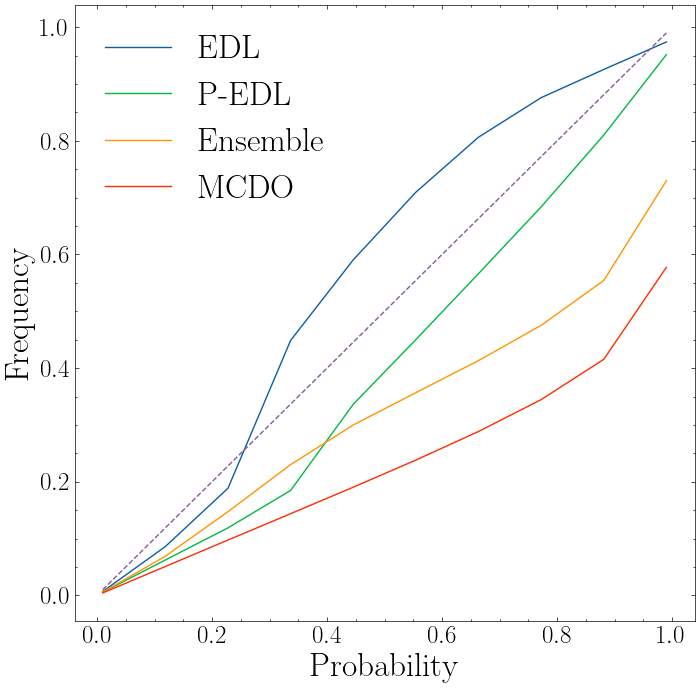

In [93]:
freqs = []
plt.figure(figsize=(8,8))

for label, modelname in model_names.items():
    print(modelname)
    
    y_vals = y_all[label]
    y_hat_vals = y_hat_all[label]
    epistemic_vals = epistemic_all[label]
    
    freq = []
    for p in prob:
        count = 0
        numels = 0
        
        for i in range(len(y_vals)):
            
            y = y_vals[i]
            y_hat = y_hat_vals[i]
            epistemic = epistemic_vals[i]
            interval = scipy_norm.interval(p, loc=y_hat, scale=epistemic.sqrt())

            count += ((y.numpy() >= interval[0]) & (y.numpy() <= interval[1])).sum()

            numels += y.numel()
            # print('p: {}, {} / {} = {}'.format(p, count, numels, np.true_divide(count, numels)))

        freq.append(np.true_divide(count, numels))
    freqs.append(freq)
    plt.plot(prob, freq, label=label)
plt.plot(prob, prob, '--')
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.xlabel("Probability", fontsize = 24)
plt.ylabel("Frequency", fontsize = 24)
plt.legend(fontsize = 24)
plt.savefig("figures/reliability.pdf", dpi=300)
plt.show()

earthformer_edl_1_drop_0
earthformer_edl_1_drop_0_pretrain
['earthformer_drop_0.1', 'earthformer_drop_0.1_1', 'earthformer_drop_0.1_2', 'earthformer_drop_0.1_3', 'earthformer_drop_0.1_4', 'earthformer_drop_0.1_5', 'earthformer_drop_0.1_6', 'earthformer_drop_0.1_7', 'earthformer_drop_0.1_8', 'earthformer_drop_0.1_9']
earthformer_drop_0.5


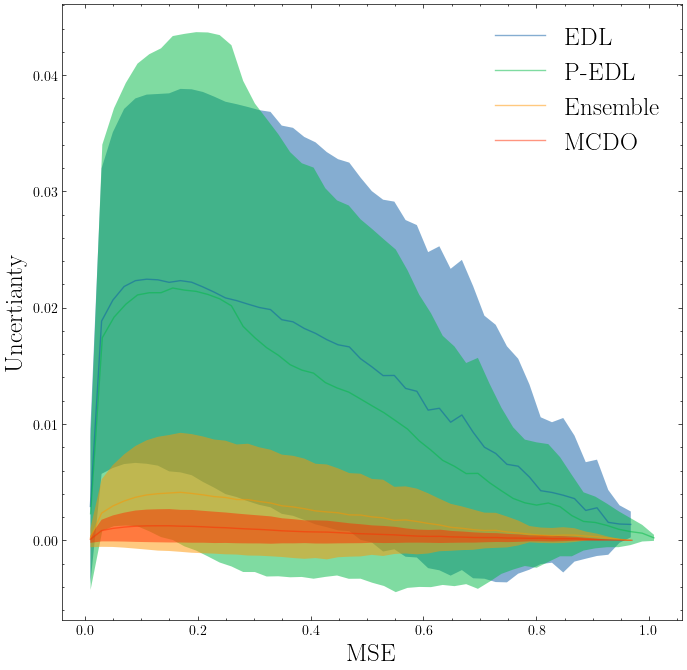

In [94]:
plt.figure(figsize=(8,8))

for label, modelname in model_names.items():
    print(modelname)
    
    epistemic_vals = epistemic_all[label]
    mse_vals = mse_all[label]
    
    errors = []
    uncs = []
    
    for i in range(len(y_vals)):
        epistemic = epistemic_vals[i].numpy()
        err = mse_vals[i].numpy()

        uncs.append(epistemic)
        errors.append(err)

    errors = np.concatenate(errors, axis=0).flatten()
    uncs = np.concatenate(uncs, axis=0).flatten()

    ul, ur = errors.min(), errors.max()
    bins = np.linspace(ul, ur, 50)
    digitized = np.digitize(errors, bins)

    bin_means = np.array([uncs[digitized == i].mean() for i in range(1, len(bins))])
    bin_stds = np.array([uncs[digitized == i].std() for i in range(1, len(bins))])
    bin_centers = np.array([bins[i-1:i+1].mean() for i in range(1, len(bins))])       

    plt.plot(bin_centers, bin_means, label=label, alpha=0.5)
    plt.fill_between(bin_centers, bin_means-bin_stds, bin_means+bin_stds, alpha=0.5)

plt.legend(fontsize = 18)
plt.ylabel("Uncertianty", fontsize = 18)
plt.xlabel("MSE", fontsize = 18)
plt.savefig("figures/UNC_MSE.pdf", dpi=300)
plt.show()

earthformer_edl_1_drop_0
earthformer_edl_1_drop_0_pretrain
['earthformer_drop_0.1', 'earthformer_drop_0.1_1', 'earthformer_drop_0.1_2', 'earthformer_drop_0.1_3', 'earthformer_drop_0.1_4', 'earthformer_drop_0.1_5', 'earthformer_drop_0.1_6', 'earthformer_drop_0.1_7', 'earthformer_drop_0.1_8', 'earthformer_drop_0.1_9']
earthformer_drop_0.5


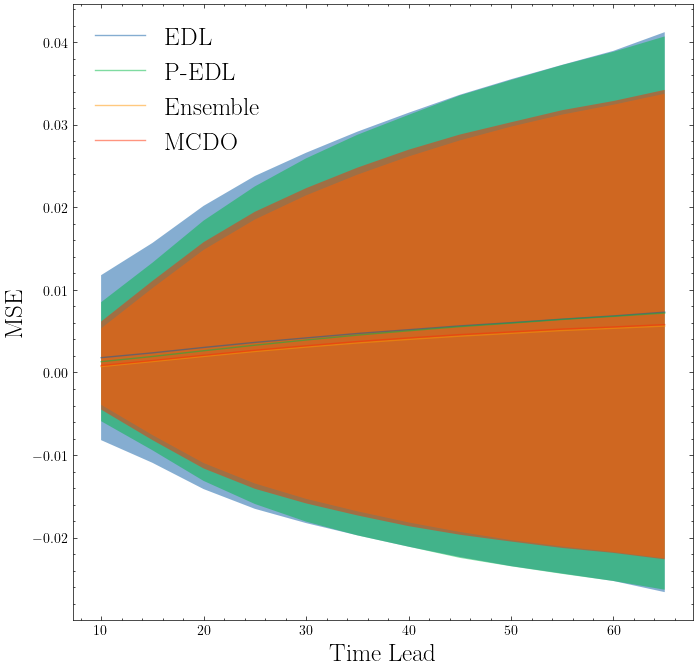

In [95]:
minutes = [5*(i+2) for i in range(12)]

plt.figure(figsize=(8,8))

for label, modelname in model_names.items():
    print(modelname)
    
    mse_vals = mse_all[label]
    
    errors = {m : [] for m in minutes}
   
    for i in range(len(y_vals)):
        err = mse_vals[i].numpy()
        
        for i in range(len(minutes)):
            errors[minutes[i]].append(err[:, i])
            
    for m in minutes:
        errors[m] = np.concatenate(errors[m], axis=0).flatten()
    
    bin_means = np.array([errors[m].mean() for m in minutes])
    bin_stds = np.array([errors[m].std() for m in minutes])

    plt.plot(minutes, bin_means, label=label, alpha=0.5)
    plt.fill_between(minutes, bin_means-bin_stds, bin_means+bin_stds, alpha=0.5)

plt.legend(fontsize = 18)
plt.ylabel("MSE", fontsize = 18)
plt.xlabel("Time Lead", fontsize = 18)
plt.savefig("figures/MSE_Time.pdf", dpi=300)
plt.show()

earthformer_edl_1_drop_0
earthformer_edl_1_drop_0_pretrain
['earthformer_drop_0.1', 'earthformer_drop_0.1_1', 'earthformer_drop_0.1_2', 'earthformer_drop_0.1_3', 'earthformer_drop_0.1_4', 'earthformer_drop_0.1_5', 'earthformer_drop_0.1_6', 'earthformer_drop_0.1_7', 'earthformer_drop_0.1_8', 'earthformer_drop_0.1_9']
earthformer_drop_0.5


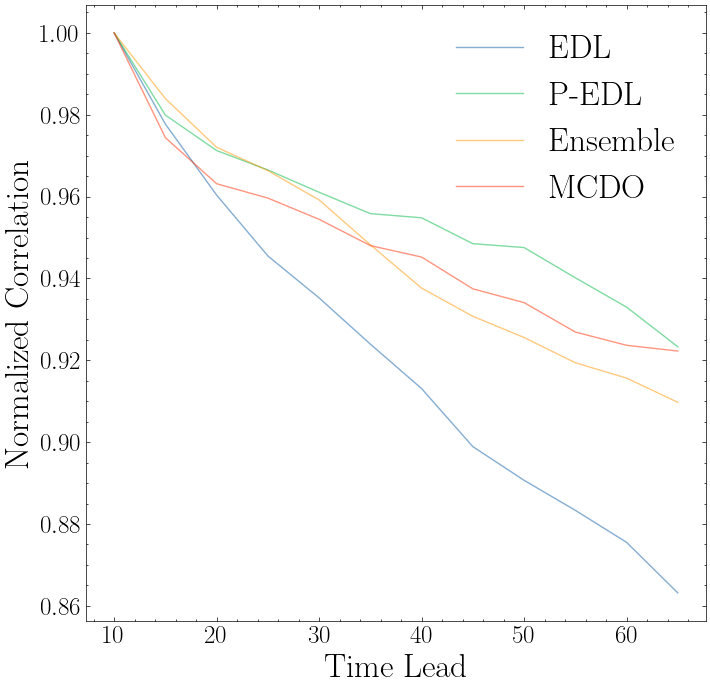

In [92]:
minutes = [5*(i+2) for i in range(12)]

plt.figure(figsize=(8,8))

for label, modelname in model_names.items():
    print(modelname)
    
    epistemic_vals = epistemic_all[label]
    mse_vals = mse_all[label]
    
    errors = {m : [] for m in minutes}
    uncs = {m : [] for m in minutes}
    
    for i in range(len(y_vals)):
        epistemic = epistemic_vals[i].sqrt().numpy()
        err = mse_vals[i].sqrt().numpy()
        
        for i in range(len(minutes)):
            errors[minutes[i]].append(err[:, i])
            uncs[minutes[i]].append(epistemic[:, i])
            
    for m in minutes:
        errors[m] = np.concatenate(errors[m], axis=0).flatten()
        uncs[m] = np.concatenate(uncs[m], axis=0).flatten()
    
    bin_means = np.array([np.corrcoef(errors[m], uncs[m])[0, 1] for m in minutes])

    plt.plot(minutes, bin_means / np.max(bin_means), label=label, alpha=0.5)

# plt.plot(minutes, np.ones_like(minutes), '--')
plt.legend(fontsize = 24)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.ylabel("Normalized Correlation", fontsize = 24)
plt.xlabel("Time Lead", fontsize = 24)
plt.savefig("figures/MSE_UNC_Corr.pdf", dpi=300)
plt.show()

In [51]:
epistemic_all["EDL"][0][None, :].shape

torch.Size([1, 1, 12, 384, 384, 1])

In [65]:
errors[10].shape

(14745600,)